# Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## Load and Preprocess the Dataset

In [2]:
iris = load_iris(as_frame=True)
x = iris.data['petal length (cm)']
y = iris.data['petal width (cm)']
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

## Create the Model from Scratch

In [3]:
class LinearRegressionFromScratch:
    LINE_PLOT_X_LIM = [-2, 8]
    LINE_PLOT_Y_LIM = [-3, 7]
    GRADIENT_PLOT_W0_LIM = [-1, 2]
    GRADIENT_PLOT_W1_LIM = [-1, 2]
    GRADIENT_PLOT_MSE_LIM = [0, 8]
    
    def __init__(self):
        self.w0 = 0
        self.w1 = 1

    def predict(self, x_param, w0_param=None, w1_param=None):
        """This is the linear function."""
        w0 = w0_param if w0_param else self.w0
        w1 = w1_param if w1_param else self.w1
        
        return w1 * x_param + w0

    def get_mean_squared_error_partial_derivative_w(self, x_param, y_param, w_j_param):
        return -2 * (w_j_param * (y_param - self.predict(x_param)))

    def run_one_epoch(self, lr, x_intercept_param, x_param, y_param):
        self.w0 -= lr * (np.sum(self.get_mean_squared_error_partial_derivative_w(
            x_param, y_param, x_intercept_param
        )) / len(x_param))
        self.w1 -= lr * (np.sum(self.get_mean_squared_error_partial_derivative_w(
            x_param, y_param, x
        )) / len(x_param))

    def get_line_coordinates(self):
        line_coordinates_x = np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1] + 1)
        line_coordinates_y = self.predict(line_coordinates_x)
            
        return line_coordinates_x, line_coordinates_y
    
    def get_mean_squared_error(self, x_param, y_param, w0_param, w1_param):
        return np.sum((y_param - self.predict(x_param, w0_param, w1_param)) ** 2) / len(x_param)
    
    def create_mse_meshgrid(self, x_param, y_param):
        step = 0.1

        w0_x, w1_y = np.mgrid[
            self.GRADIENT_PLOT_W0_LIM[0]:self.GRADIENT_PLOT_W0_LIM[1]:step,
            self.GRADIENT_PLOT_W1_LIM[0]:self.GRADIENT_PLOT_W1_LIM[1]:step
        ]
        mse_z = np.array([
            [self.get_mean_squared_error(x_param, y_param, w0_x[i][j], w1_y[i][j]) 
             for j in range(w0_x.shape[1])]
            for i in range(w0_x.shape[0])
        ])
        mse_z = np.clip(mse_z, self.GRADIENT_PLOT_MSE_LIM[0], self.GRADIENT_PLOT_MSE_LIM[1])
    
        return w0_x, w1_y, mse_z
    
    def animate_line_plot(self, frame, ax1, line_coordinates_x_frames, line_coordinates_y_frames):
        ax1.clear()
        ax1.set_xlim(self.LINE_PLOT_X_LIM)
        ax1.set_ylim(self.LINE_PLOT_Y_LIM)
        ax1.axhline(0, color='black')
        ax1.axvline(0, color='black')
        ax1.scatter(x, y, edgecolors='black')
        ax1.plot(line_coordinates_x_frames[frame], line_coordinates_y_frames[frame], color='red')
        ax1.set_axisbelow(True)
        ax1.grid(color='grey')
        ax1.set_title(f"Epoch: {frame + 1}")
        ax1.set_xlabel('petal length (cm)')
        ax1.set_ylabel('petal width (cm)')
        ax1.set_xticks(np.arange(self.LINE_PLOT_X_LIM[0], self.LINE_PLOT_X_LIM[1]))
        ax1.set_yticks(np.arange(self.LINE_PLOT_Y_LIM[0], self.LINE_PLOT_Y_LIM[1]))
    
    def animate_gradient_plot(self, frame, ax2,  w0_frames, w1_frames, mse_frames, mse_meshgrid):
        ax2.clear()
        ax2.view_init(azim=170 + (frame / 4), elev=30)
        ax2.set_xlim(self.GRADIENT_PLOT_W0_LIM)
        ax2.set_ylim(self.GRADIENT_PLOT_W1_LIM)
        ax2.set_zlim(self.GRADIENT_PLOT_MSE_LIM)
        ax2.plot_surface(mse_meshgrid[0], mse_meshgrid[1], mse_meshgrid[2], cmap=cm.coolwarm,
                         alpha=0.5)
        ax2.scatter(w0_frames[frame], w1_frames[frame], mse_frames[frame], color='red')
        ax2.set_title((f"MSE={mse_frames[frame]:.5f} ($w_0$={w0_frames[frame]:.3f}, "
                       f"$w_1$={w1_frames[frame]:.3f})"))
        ax2.set_xlabel('$w_0$ parameter')
        ax2.set_ylabel('$w_1$ parameter')
        ax2.set_zlabel('MSE')
        ax2.set_xticks(np.arange(self.GRADIENT_PLOT_W0_LIM[0], self.GRADIENT_PLOT_W0_LIM[1]))
        ax2.set_yticks(np.arange(self.GRADIENT_PLOT_W1_LIM[0], self.GRADIENT_PLOT_W1_LIM[1]))
        ax2.set_zticks(np.arange(self.GRADIENT_PLOT_MSE_LIM[0], self.GRADIENT_PLOT_MSE_LIM[1]))
    
    def animate(self, frame, ax1, ax2, line_coordinates_x_frames, line_coordinates_y_frames, 
                w0_frames, w1_frames, mse_frames, mse_meshgrid):
        self.animate_line_plot(frame, ax1, line_coordinates_x_frames, line_coordinates_y_frames)
        self.animate_gradient_plot(frame, ax2,  w0_frames, w1_frames, mse_frames, mse_meshgrid)
    
    def fit(self, x_param, y_param, lr=0.01, epochs=100, create_animation=False):
        if len(x_param.shape) != 1:
            raise Exception(("This linear regression implementation works only with "
                             "one-dimensional features!"))
        if create_animation:
            n = len(x_param)
            x_intercept = np.ones(n)
            
            line_coordinates_x_frames = []
            line_coordinates_y_frames = []
            w0_frames = []
            w1_frames = []
            mse_frames = []
            
            for epoch in range(epochs):
                self.run_one_epoch(lr, x_intercept, x_param, y_param)
    
                line_coordinates_x, line_coordinates_y = self.get_line_coordinates()
                mse = self.get_mean_squared_error(x_param, y_param, self.w0, self.w1)
                
                line_coordinates_x_frames.append(line_coordinates_x)
                line_coordinates_y_frames.append(line_coordinates_y)
                w0_frames.append(self.w0)
                w1_frames.append(self.w1)
                mse_frames.append(mse)
            
            mse_meshgrid = self.create_mse_meshgrid(x_param, y_param)
    
            fig = plt.figure(figsize=plt.figaspect(2.))
            ax1 = fig.add_subplot(2, 1, 1)
            ax2 = fig.add_subplot(2, 1, 2, projection='3d')
            animation = FuncAnimation(fig, self.animate, epochs, fargs=(
                ax1, ax2, line_coordinates_x_frames, line_coordinates_y_frames, 
                w0_frames, w1_frames, mse_frames, mse_meshgrid
            ))
    
            fig.subplots_adjust(left=0.15, bottom=0.05, top=0.95, hspace=0.3)
            animation.save('linear_regression.gif', writer=PillowWriter(fps=20), dpi=200)
        else:
            x_mean = np.mean(x_param)
            y_mean = np.mean(y_param)
            x_deviation = x_param - x_mean
            y_deviation = y_param - y_mean
            
            self.w1 = np.sum(x_deviation * y_deviation) / np.sum(x_deviation ** 2)
            self.w0 = y_mean - (self.w1 * x_mean)

## Create an Animation

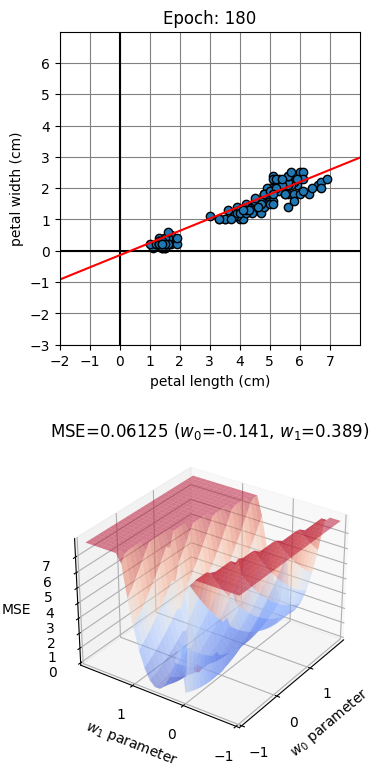

In [4]:
model_from_scratch = LinearRegressionFromScratch()

model_from_scratch.fit(x_train, y_train, lr=0.0005, epochs=180, create_animation=True)

## Compare Implementations

In [5]:
model_from_scratch = LinearRegressionFromScratch()

model_from_scratch.fit(x_train, y_train)

y_pred = model_from_scratch.predict(x_test)

mean_squared_error(y_test, y_pred)

0.03855843593099838

In [6]:
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)

In [7]:
model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

mean_squared_error(y_test, y_pred)

0.03855843593099837